<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/AutomacaoNegocios_SegundaIdeia_Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Iniciando o estudo da segunda ideia de parâmetros de avaliação (13/08/2020)

# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
import datetime
import pickle
import seaborn as sns
from numpy.random import seed

from sklearn.model_selection import train_test_split
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.activations import relu, sigmoid
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#define um SEED para o processo de forma a ter resultados comparáveis
seed(1)

In [3]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/MAI - JUN - JUL - TTO v2 10h15 em diante - Final.csv", sep=";", decimal=",")

In [4]:
historic.head()

,Data,Hora,DOLAR,ÍNDICE,VALE3,ITUB4,CMIG4,LAME4,Dolar_Target_5m,Dolar_Target_10m,Dolar_Target_15m,Dolar_Target_20m,Dolar_Target_30m,Dolar_Target_1h,Indice_Target_5m,Indice_Target_10m,Indice_Target_15m,Indice_Target_20m,Indice_Target_30m,Indice_Target_1h,Vale_Target_5m,Vale_Target_10m,Vale_Target_15m,Vale_Target_20m,Vale_Target_30m,Vale_Target_1h
0,04/05/2020,10:15:21,-47.36,88.39,18.28,-4.56,-10.93,0.0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1
1,04/05/2020,10:15:41,-47.36,91.56,11.43,4.56,-10.93,0.0,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1
2,04/05/2020,10:16:05,-44.67,90.29,4.58,-4.56,0.00,0.0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1
3,04/05/2020,10:16:29,-43.77,90.93,27.39,-32.04,-10.93,0.0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1
4,04/05/2020,10:16:47,-43.77,87.75,29.67,-22.86,0.00,0.0,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1


In [5]:
historic.describe

<bound method NDFrame.describe of              Data      Hora  ...  Vale_Target_30m  Vale_Target_1h
0      04/05/2020  10:15:21  ...                1               1
1      04/05/2020  10:15:41  ...                1               1
2      04/05/2020  10:16:05  ...                1               1
3      04/05/2020  10:16:29  ...                1               1
4      04/05/2020  10:16:47  ...                1               1
...           ...       ...  ...              ...             ...
77388  31/07/2020  17:57:38  ...                0               0
77389  31/07/2020  17:58:17  ...                0               0
77390  31/07/2020  17:58:39  ...                0               0
77391  31/07/2020  17:59:19  ...                0               0
77392  31/07/2020  17:59:37  ...                0               0

[77393 rows x 26 columns]>

In [6]:
tabelaAjustada = historic.drop(['Data', 'Hora'], axis=1)
tabelaAjustada = tabelaAjustada.iloc[:,0:7]

In [7]:
tabelaAjustada.head()

,DOLAR,ÍNDICE,VALE3,ITUB4,CMIG4,LAME4,Dolar_Target_5m
0,-47.36,88.39,18.28,-4.56,-10.93,0.0,1
1,-47.36,91.56,11.43,4.56,-10.93,0.0,1
2,-44.67,90.29,4.58,-4.56,0.00,0.0,1
3,-43.77,90.93,27.39,-32.04,-10.93,0.0,1
4,-43.77,87.75,29.67,-22.86,0.00,0.0,1


In [8]:
tabelaAjustada.describe

<bound method NDFrame.describe of        DOLAR  ÍNDICE  VALE3   ITUB4   CMIG4   LAME4  Dolar_Target_5m
0     -47.36   88.39  18.28   -4.56  -10.93    0.00                1
1     -47.36   91.56  11.43    4.56  -10.93    0.00                1
2     -44.67   90.29   4.58   -4.56    0.00    0.00                1
3     -43.77   90.93  27.39  -32.04  -10.93    0.00                1
4     -43.77   87.75  29.67  -22.86    0.00    0.00                1
...      ...     ...    ...     ...     ...     ...              ...
77388  66.97 -233.89 -60.93 -340.36 -149.13 -310.85                1
77389  71.72 -233.89 -55.96 -332.72 -182.88 -307.83                1
77390  70.77 -233.89 -64.24 -332.72 -182.88 -307.83                1
77391  67.92 -233.89 -54.30 -332.72 -182.88 -292.74                1
77392  71.72 -233.89 -65.90 -328.90 -182.88 -292.74                1

[77393 rows x 7 columns]>

# Criando um arquivo para treino e outro para teste

In [9]:
#separa as features do target
X = tabelaAjustada.iloc[:,0:6]
y = tabelaAjustada.iloc[:,6:]
print(X.describe, y.describe)

<bound method NDFrame.describe of        DOLAR  ÍNDICE  VALE3   ITUB4   CMIG4   LAME4
0     -47.36   88.39  18.28   -4.56  -10.93    0.00
1     -47.36   91.56  11.43    4.56  -10.93    0.00
2     -44.67   90.29   4.58   -4.56    0.00    0.00
3     -43.77   90.93  27.39  -32.04  -10.93    0.00
4     -43.77   87.75  29.67  -22.86    0.00    0.00
...      ...     ...    ...     ...     ...     ...
77388  66.97 -233.89 -60.93 -340.36 -149.13 -310.85
77389  71.72 -233.89 -55.96 -332.72 -182.88 -307.83
77390  70.77 -233.89 -64.24 -332.72 -182.88 -307.83
77391  67.92 -233.89 -54.30 -332.72 -182.88 -292.74
77392  71.72 -233.89 -65.90 -328.90 -182.88 -292.74

[77393 rows x 6 columns]> <bound method NDFrame.describe of        Dolar_Target_5m
0                    1
1                    1
2                    1
3                    1
4                    1
...                ...
77388                1
77389                1
77390                1
77391                1
77392                1

[773

In [10]:
# Separando uma parte para treino (90%) e outra para validação (10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=9)
print('Qtde de treino: {}'.format(len(X_train)))
print('Qtde de validação: {}'.format(len(y_val)))

Qtde de treino: 69653
Qtde de validação: 7740


# Modelagem

In [11]:
#define o callback para checkpoint
filepath = 'checkpoint.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
#define o callback para evitar falso plato
alpha = 1e-5
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

In [13]:
#cria uma variável para todos os callbacks
#callbacks = [checkpoint, lr_reduce]  neste faz a modificação em caso de platô
callbacks = [checkpoint]

In [14]:
def create_model(optimizer, learn_rate=0.01):
  model = Sequential()
  model.add(Dense(5, input_dim=X_train.shape[1], activation='relu'))
  # Dropout de 20%
  model.add(Dropout(0.2))
  model.add(Dense(5, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) #softmax

  model.compile(optimizer = optimizer, 
                loss = 'binary_crossentropy',
                metrics=['acc'])
  return model

model = KerasClassifier(build_fn=create_model)  

In [15]:
#definição de parâmetros de otiização para comparação da melhor combinação
batch_size =  [len(X_train), 64]
epochs = [100, 200, 300]
optimizer = ['RMSprop', 'Adam']

#deixando mais simples para teste inicial
epochs = [100]

param_grid = dict(optimizer = optimizer, batch_size = batch_size, epochs = epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [16]:
grid_result = grid.fit(X_train, y_train, callbacks = callbacks, validation_data=(X_val, y_val))

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - ETA: 0s - loss: 17.1132 - acc: 0.5044
Epoch 00054: val_acc did not improve from 0.51344
1/1 [==============================] - 0s 15ms/step - loss: 17.1132 - acc: 0.5044 - val_loss: 16.0338 - val_acc: 0.5050
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 17.0200 - acc: 0.4996
Epoch 00055: val_acc did not improve from 0.51344
1/1 [==============================] - 0s 16ms/step - loss: 17.0200 - acc: 0.4996 - val_loss: 15.8521 - val_acc: 0.5044
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 16.7426 - acc: 0.5023
Epoch 00056: val_acc did not improve from 0.51344
1/1 [==============================] - 0s 15ms/step - loss: 16.7426 - acc: 0.5023 - val_loss: 15.6719 - val_acc: 0.5031
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 16.6102 - acc: 0.5010
Epoch 00057: val_acc did not improve from 0.51344
1/1 [=============================

In [17]:
#visualiza o resumo dos resultados
print('Melhor resultado: {:.2f}% usando {}'.format(grid_result.best_score_, grid_result.best_params_))
media = grid_result.cv_results_['mean_test_score']
desvio = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for media, desvio, params in zip(media, desvio, params):
  print('{:.2f} ({:.2f}) com {}'.format(media, desvio, params))

Melhor resultado: 0.51% usando {'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}
0.50 (0.01) com {'batch_size': 69653, 'epochs': 100, 'optimizer': 'RMSprop'}
0.50 (0.00) com {'batch_size': 69653, 'epochs': 100, 'optimizer': 'Adam'}
0.51 (0.00) com {'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}
0.51 (0.01) com {'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}


In [18]:
#recupera o melhor melhor modelo
model = load_model(filepath)

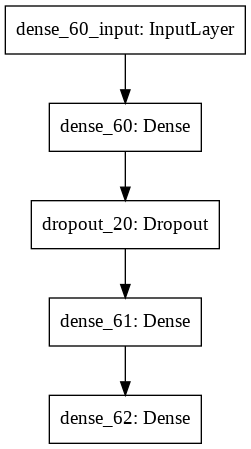

In [19]:
#plota o modelo
plot_model(model)

In [20]:
#faz predição com dados de validacao
valoresPrevistos = model.predict(X_val)
valoresPrevistos

array([[0.48725516],
       [0.48314133],
       [0.49408484],
       ...,
       [0.51875055],
       [0.48314133],
       [0.51533014]], dtype=float32)

In [21]:
y_val.values

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [22]:
#avalia os resultados da modelagen
def avaliaResultado(y_test, valoresPrevistos):
  #lista quantidade de acertos
  contaOk = 0
  contaNao = 0
  contaDesconsiderados = 0
  for i in range(0, len(y_test)):
    valorAjustado = int(round(valoresPrevistos[i][0]))
    #print(valorAjustado, y_test[i])
    if valorAjustado == 1  and y_test[i] == 1:
      contaOk += 1
    elif valorAjustado == 1  and y_test[i] == 0:
      contaNao += 1
    else:
      contaDesconsiderados += 1

  return contaOk, contaNao, contaDesconsiderados, contaOk/(contaOk+contaNao)*100

In [23]:
#avalia as respostas
sim, nao, desprezados, percentual = avaliaResultado(y_val.values, valoresPrevistos)

#print("* {} * {}: {:.2f}%    Percentual de acertos: {:.1f}%: ".format(i, model.metrics_names[1], score[1]*100, percentual))
print('Sim', sim)
print('Não', nao)
print('Desprezados', desprezados)
print('Percentual', percentual)

Sim 1085
Não 912
Desprezados 5743
Percentual 54.331497245868796
